In [1]:
import numpy
import torch
import torch.nn as nn
from collections import OrderedDict
import os
import sys
import warnings
from torch.utils.data import DataLoader
import argparse
import time
import copy
import math
import torchvision.utils as vision_utils
import json
import numpy as np
from torch.distributions import bernoulli
from scipy import linalg
import torchvision.datasets as _datasets
import torchvision.transforms as _transforms
import matplotlib.pyplot as plt
import shutil

from data import Binarize, Smooth, load_mnist, get_sampler
from evals import compute_mu_sigma_pretrained_model, calculate_frechet_distance, _calculate_metrics, get_metrics
from losses import get_disciminator_loss, get_generator_loss
from model import DiscriminatorCNN28, GeneratorCNN28, MLP_mnist, pretrained_mnist_model
from trainer import train
from updates import Lookahead, update_avg_gen, update_ema_gen
from utils import save_models, get_plot_func, get_num_params

In [2]:
a = 1

In [3]:
_NOISE_DIM = 4
_H_FILTERS = 2

In [4]:
G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

In [5]:
get_num_params(G)

3256

In [6]:
get_num_params(D)

768

Loading trained model from ./drive/My Drive/Data/models/mnist.pth
Iter 0: Mean proba from D(G(z)): 0.6463 +/- 0.0835


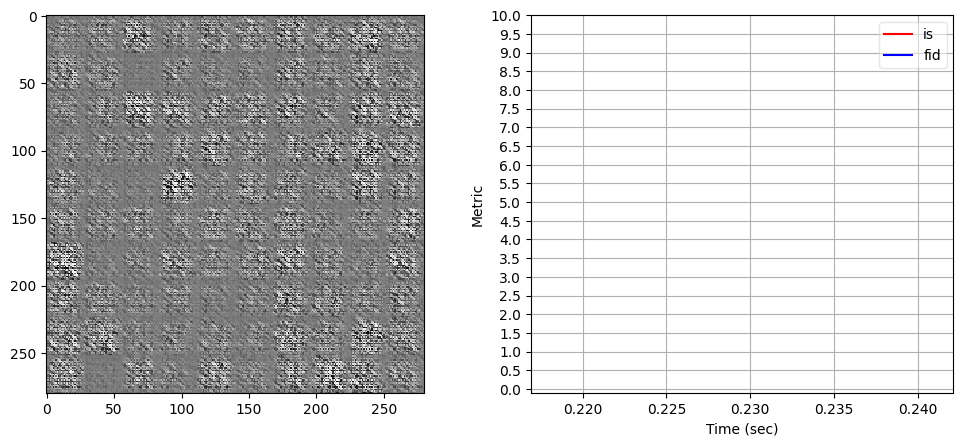

Iter 5000: Mean proba from D(G(z)): 0.4963 +/- 0.0030


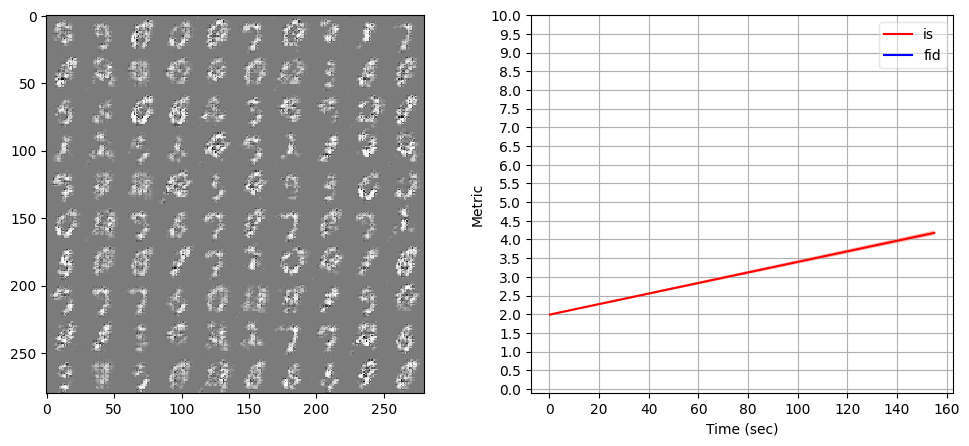

Iter 10000: Mean proba from D(G(z)): 0.4961 +/- 0.0079


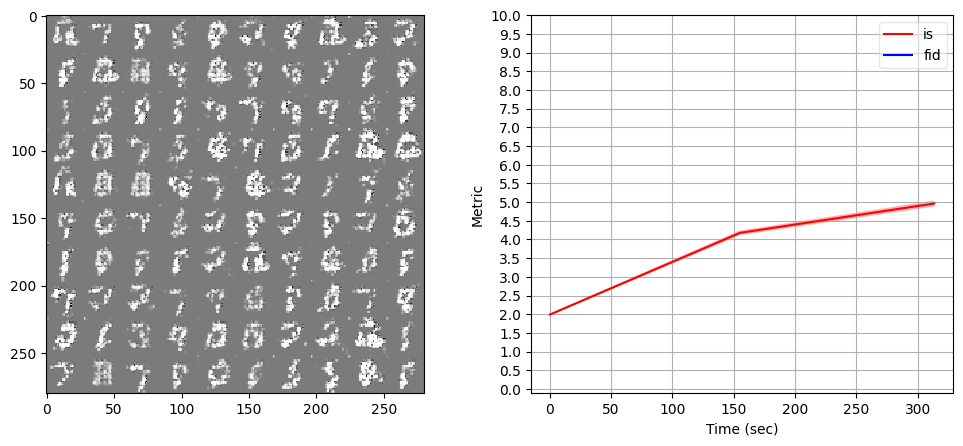

Iter 15000: Mean proba from D(G(z)): 0.4985 +/- 0.0198


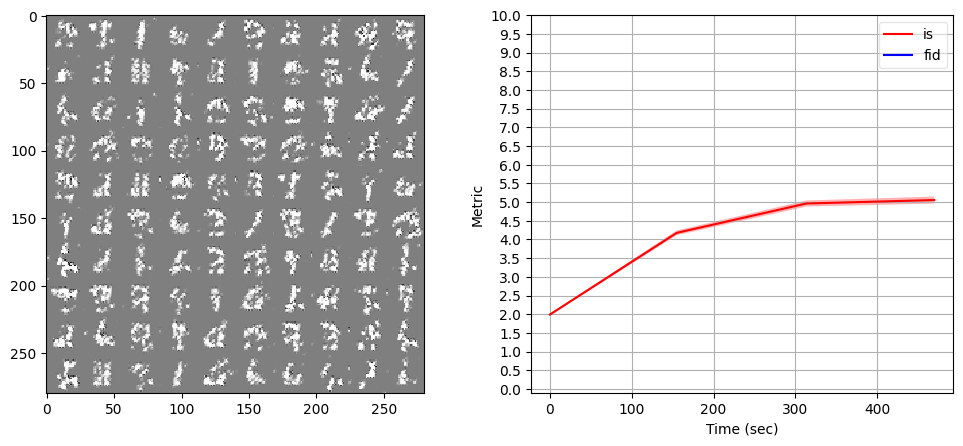

Iter 20000: Mean proba from D(G(z)): 0.4756 +/- 0.0459


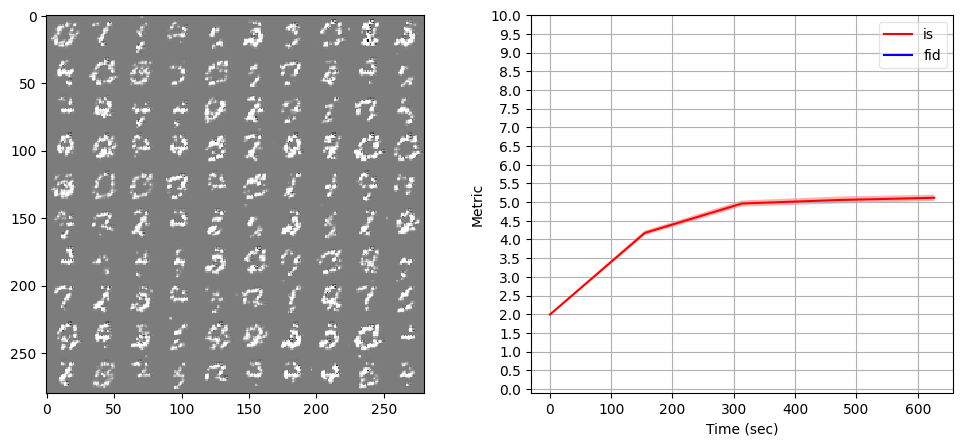

Iter 25000: Mean proba from D(G(z)): 0.3761 +/- 0.0881


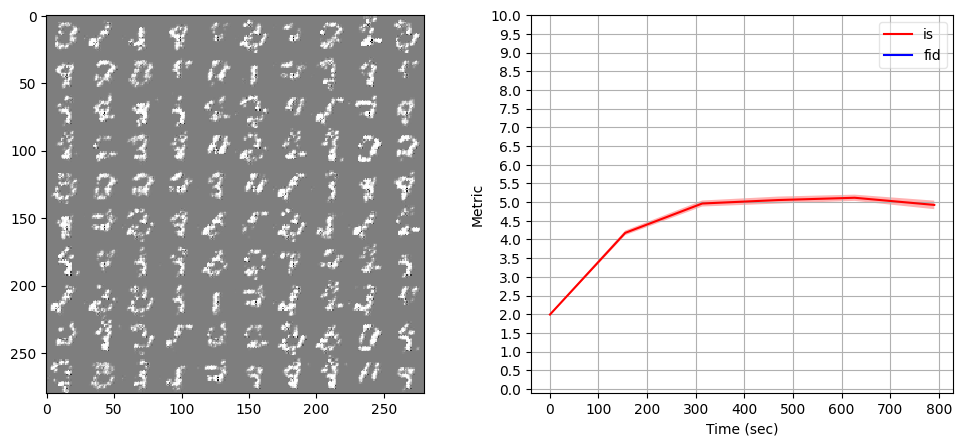

Iter 30000: Mean proba from D(G(z)): 0.5274 +/- 0.0857


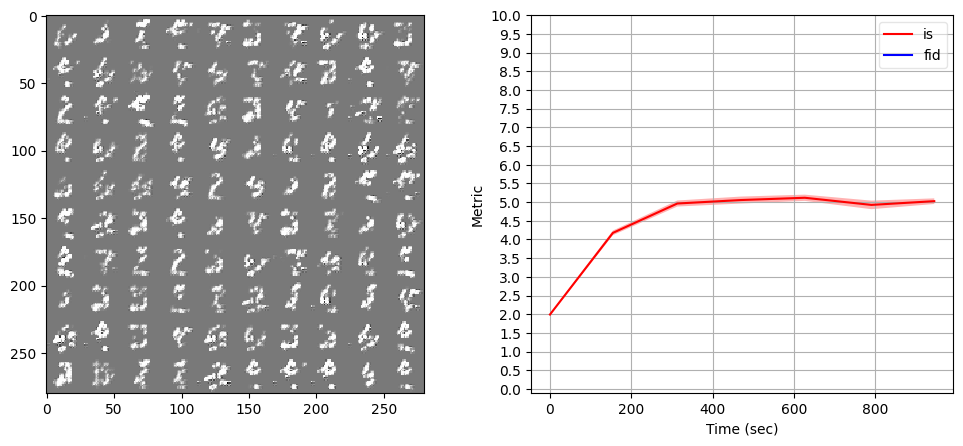

Iter 35000: Mean proba from D(G(z)): 0.4636 +/- 0.1019


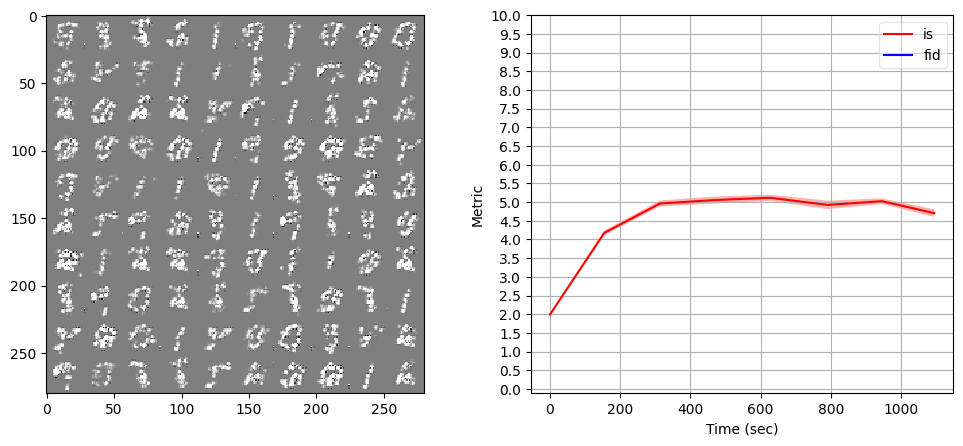

Iter 40000: Mean proba from D(G(z)): 0.4265 +/- 0.0944


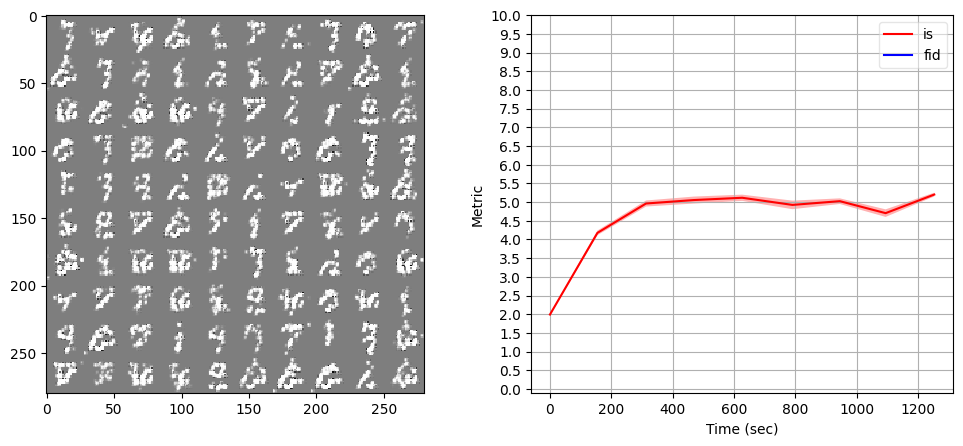

Iter 45000: Mean proba from D(G(z)): 0.4817 +/- 0.1197


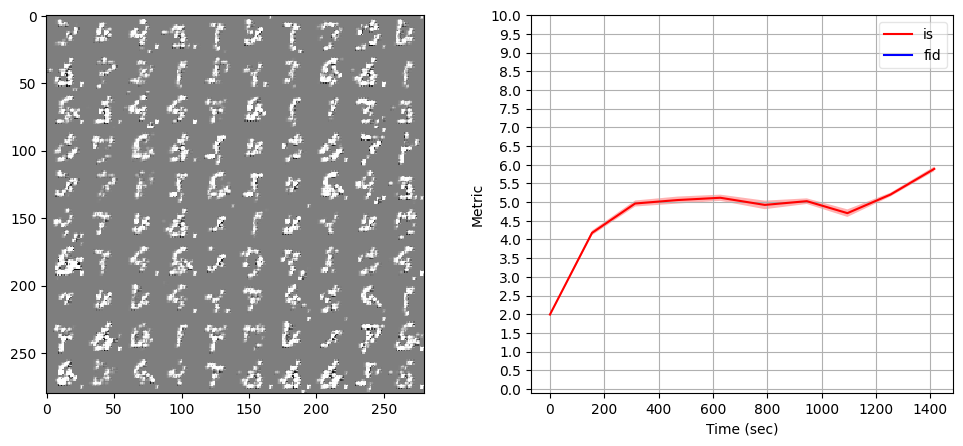

Iter 50000: Mean proba from D(G(z)): 0.4375 +/- 0.0872


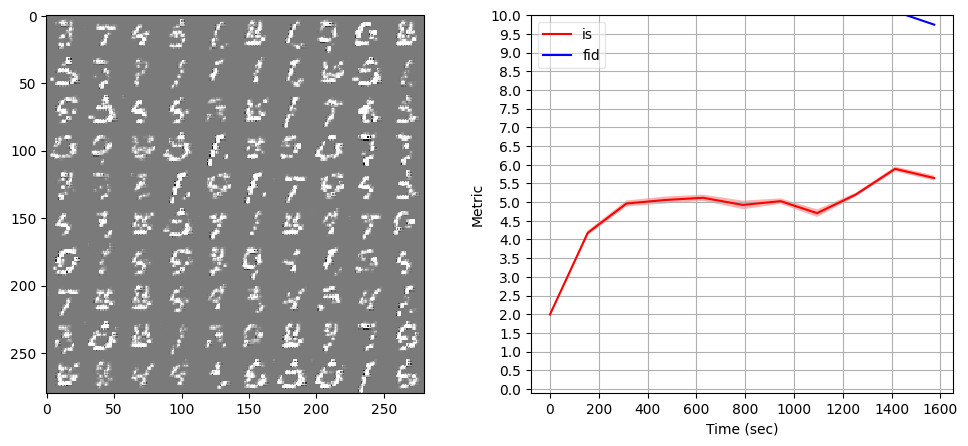

Iter 55000: Mean proba from D(G(z)): 0.4515 +/- 0.1299


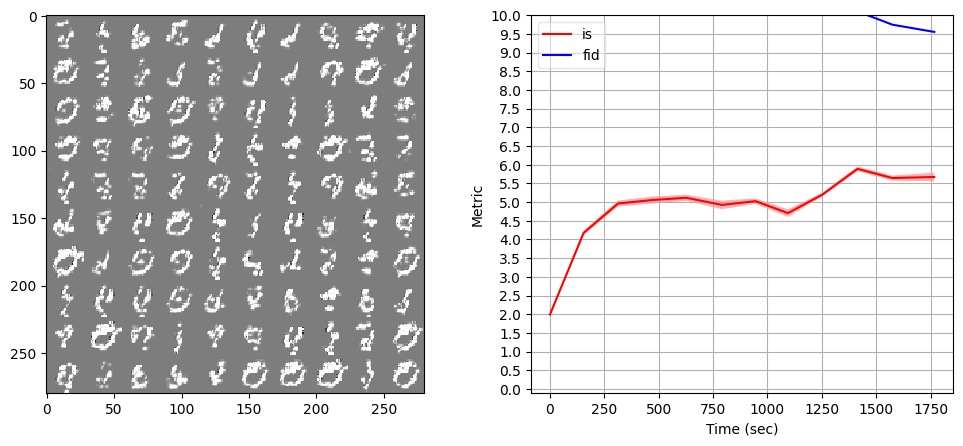

Iter 60000: Mean proba from D(G(z)): 0.3712 +/- 0.1408


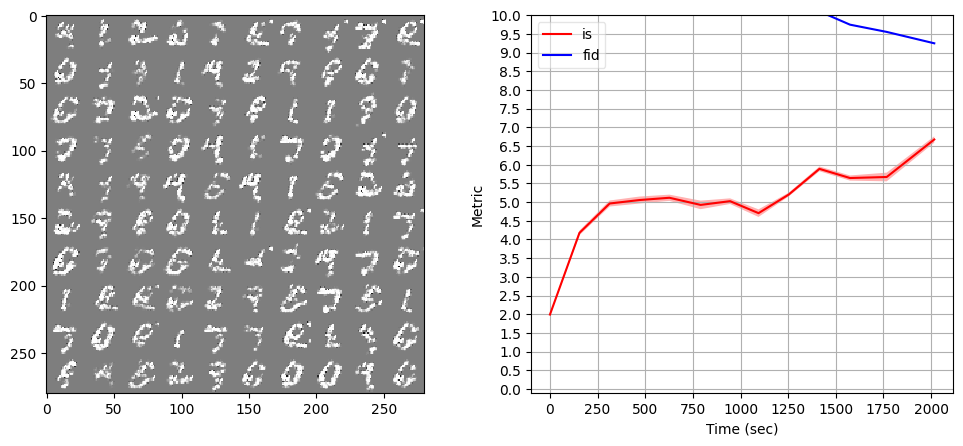

Iter 65000: Mean proba from D(G(z)): 0.3079 +/- 0.1513


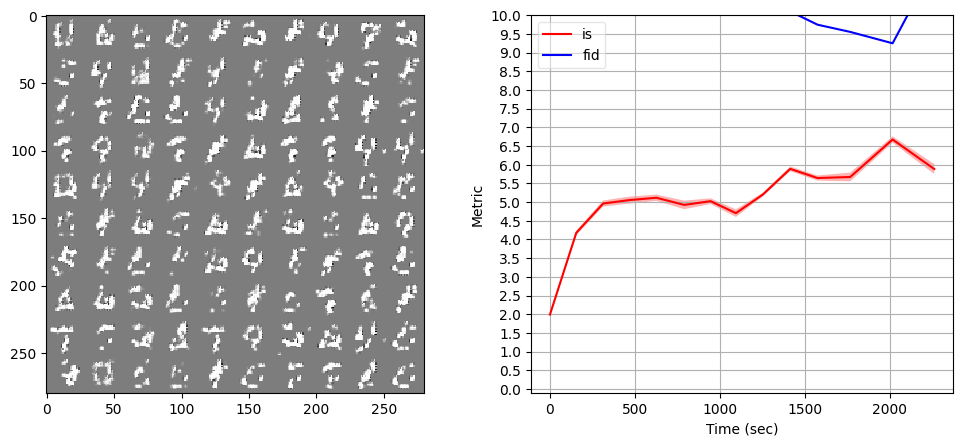

Iter 70000: Mean proba from D(G(z)): 0.4258 +/- 0.1327


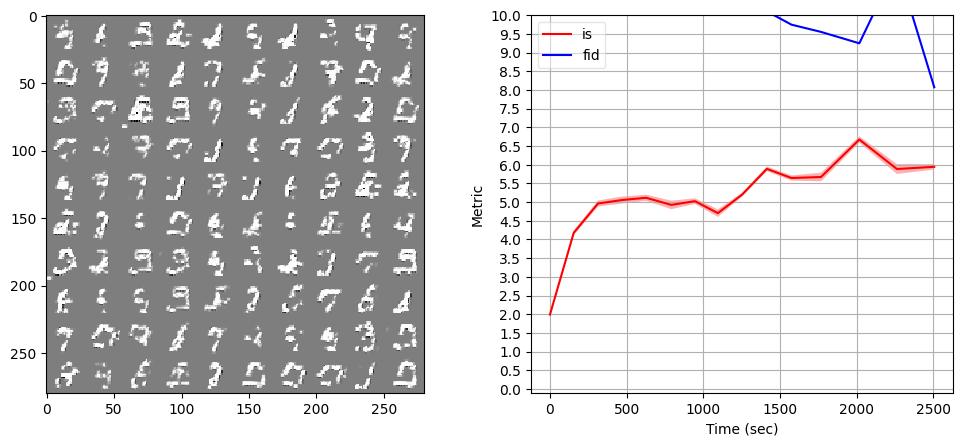

Iter 75000: Mean proba from D(G(z)): 0.3733 +/- 0.1397


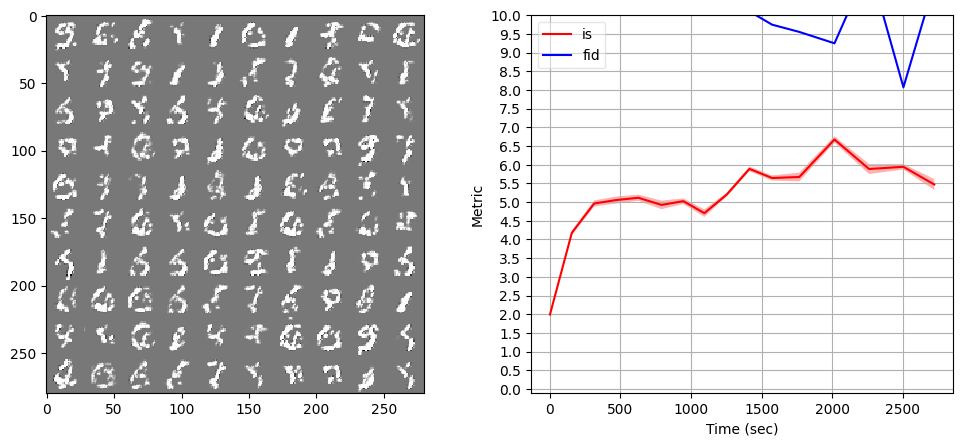

Iter 80000: Mean proba from D(G(z)): 0.3836 +/- 0.1484


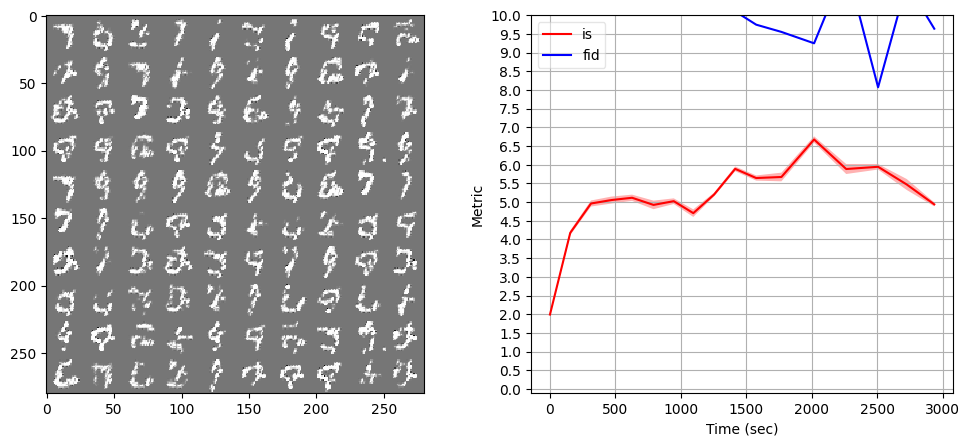

Iter 85000: Mean proba from D(G(z)): 0.4712 +/- 0.1964


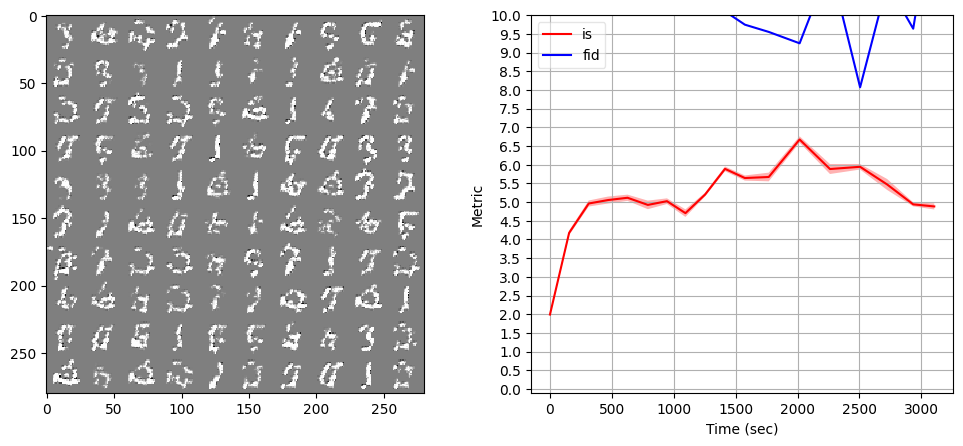

Iter 90000: Mean proba from D(G(z)): 0.3586 +/- 0.1555


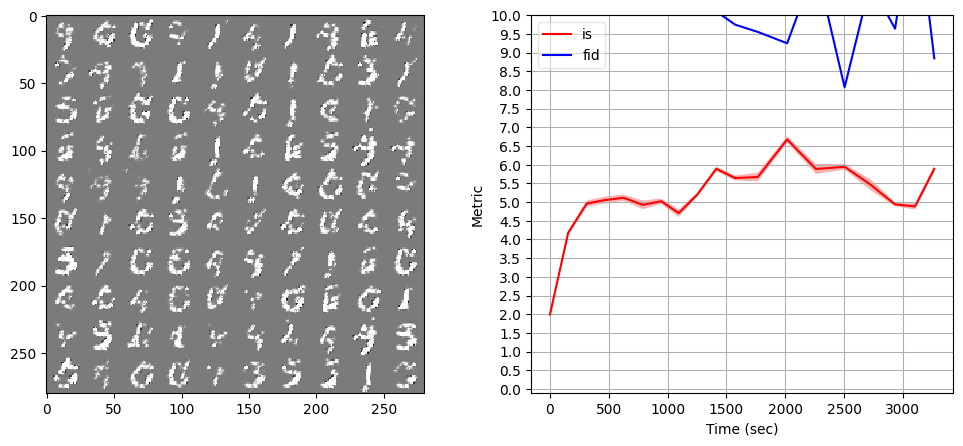

Iter 95000: Mean proba from D(G(z)): 0.1972 +/- 0.1382


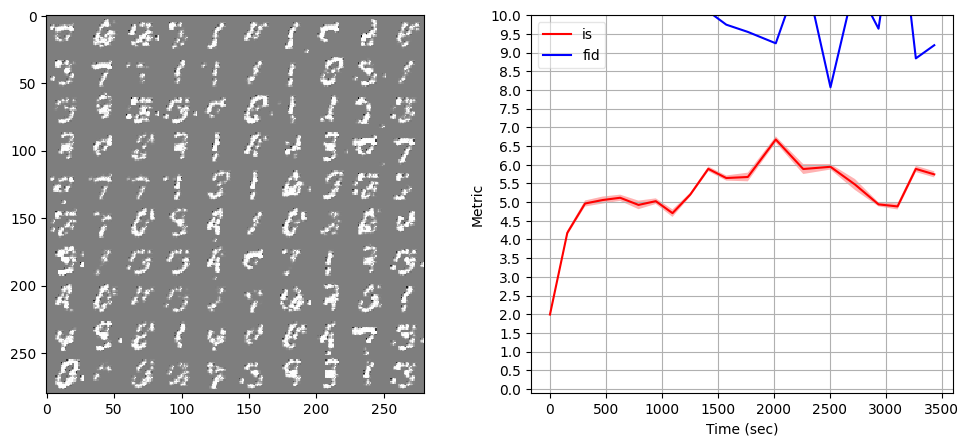

Iter 99999: Mean proba from D(G(z)): 0.2040 +/- 0.1473


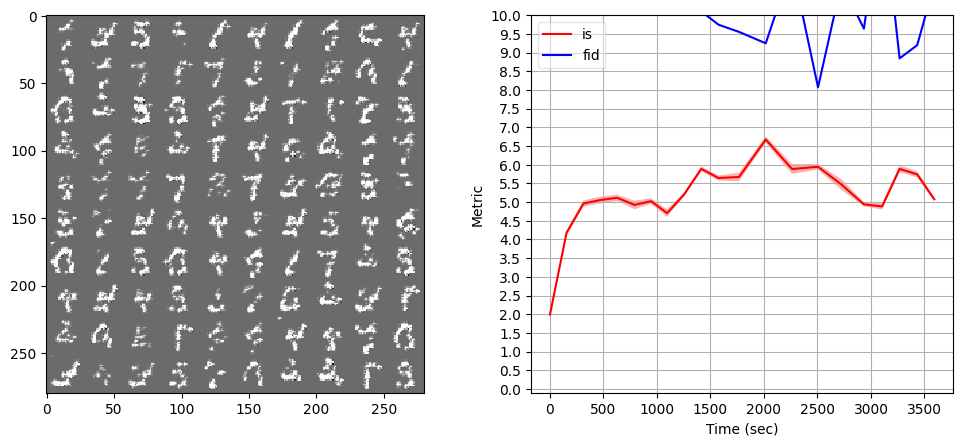

In [7]:
args = dict(iterations = 100000,
            batch_size = 256,
            lrD = 0.001,
            lrG = 0.001,
            beta1 = 0.05,
            extragrad = False,
            eval_every = 5000,
            lookahead = False,
            eval_avg = False,
            lookahead_k = 1000,
            n_workers = 5,
            device = 'cuda',
            grad_max_norm = None)


for k in range(1,1+1):
  exp_key = f"iter{args['iterations']}_bs{args['batch_size']}_lrD{args['lrD']}" + \
            f"_lrG{args['lrG']}_beta1{args['beta1']}_lookahead{args['lookahead']}" + \
            f"_lak{args['lookahead_k']}" + \
            f"_extragrad{args['extragrad']}_ee{args['eval_every']}"
  out_dir = f"/home/mila/t/tianyu.zhang/GAN_LOLA/drive/My Drive/results/final/{exp_key}/{k}/"

  shutil.rmtree(out_dir, ignore_errors=True)
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)

  with open(os.path.join(out_dir, 'args.json'), 'w') as fs:
    json.dump(args, fs)

  dataset = load_mnist(_data_root='datasets', binarized=False)

  plot_func = get_plot_func(out_dir=out_dir, 
                            img_size=dataset[0][0].size(),
                            num_samples_eval=10000)

  G = GeneratorCNN28(noise_dim=_NOISE_DIM, h_filters=_H_FILTERS, out_tanh=True)
  D = DiscriminatorCNN28(h_filters=_H_FILTERS, spectral_norm=False, img_size=28)

  train(G, D, dataset, 
        iterations=args['iterations'], 
        batch_size=args['batch_size'], 
        lookahead=args['lookahead'],
        lookahead_k=args['lookahead_k'],
        eval_avg=args['eval_avg'],
        lrD=args['lrD'], 
        lrG=args['lrG'], 
        beta1=args['beta1'], 
        extragrad=args['extragrad'],
        eval_every=args['eval_every'], 
        n_workers=args['n_workers'], 
        device=torch.device(args['device']), 
        grad_max_norm=args['grad_max_norm'], 
        plot_func=plot_func,
        out_dir=out_dir)